# 機器學習及應用_期末報告

## 功能描述 : 針對年滿 21 歲的印度女性，是否有患有糖尿病進行檢測
### 作法 : 先將資料集分成 train & test ，進行訓練；模型使用RandomForestClassifier
### 找出資料中的特徵對於預測結果的重要性；進行篩選後訓練和比較

####  學號 : F112112131 姓名: 謝秉君

In [1]:
import pandas as pd
import numpy as np
# 繪圖相關套件
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use( 'ggplot' ) 
# 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
# 決策樹(Decision Tree)
from sklearn.tree import DecisionTreeClassifier
# 隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
# Feature Engineering libraries
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, DropMissingData
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings( 'ignore' )

# ***讀取訓練資料*** #

In [2]:
df_train = pd.read_csv('train.csv')
print( f'train {df_train.shape}' )
display( df_train.head() )

train (612, 10)


,PassengerId,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,1
1,1,1,85,66,29,0,26.6,0.351,31,0
2,2,8,183,64,0,0,23.3,0.672,32,1
3,3,1,89,66,23,94,28.1,0.167,21,0
4,4,0,137,40,35,168,43.1,2.288,33,1


## 讀取測試資料沒有陰陽性這個欄位 ##

In [3]:
df_test = pd.read_csv('test.csv')
print( f'test {df_test.shape}' )
display( df_test.head() )

test (158, 9)


,PassengerId,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,610,3,106,54,21,158,30.9,0.292,24
1,611,3,174,58,22,194,32.9,0.593,36
2,612,7,168,88,42,321,38.2,0.787,40
3,613,6,105,80,28,0,32.5,0.878,26
4,614,11,138,74,26,144,36.1,0.557,50


## 查看各個欄位的資料型態 ##

In [4]:
def Col_Types( Data ):
    Column_Types = Data.dtypes.to_frame().reset_index()
    Column_Types.columns = ['ColumnName','Type']
    Column_Types.sort_values( by='Type', inplace=True ) 
    return Column_Types
print( Col_Types(df_train) )

                 ColumnName     Type
0               PassengerId    int64
1               Pregnancies    int64
2                   Glucose    int64
3             BloodPressure    int64
4             SkinThickness    int64
5                   Insulin    int64
8                       Age    int64
9                   Outcome    int64
6                       BMI  float64
7  DiabetesPedigreeFunction  float64


## 可以知道這個資料集一共有多少欄位，並且每個資料的形式是什麼。

# --下面來看一下資料集的特徵-- #

In [5]:
FEATURES = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

### 葡萄糖濃度 、血壓 、皮脂厚度 、胰島素濃度、BMI 、家族遺傳機率、年齡 ###
### 其中不為 0 或 NaN 的特徵有底下這些 ###
### ***葡萄糖濃度 、血壓 、皮脂厚度 、胰島素濃度、BMI 、年齡*** ###
### 底下建立一個針對缺失值的陣列，將上述的特徵放入 ###

In [6]:
Missing_FEATURES = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age']

In [7]:
# 合併train及test的資料 
df_data = pd.concat([df_train, df_test])
df_data 

,PassengerId,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,1.0
1,1,1,85,66,29,0,26.6,0.351,31,0.0
2,2,8,183,64,0,0,23.3,0.672,32,1.0
3,3,1,89,66,23,94,28.1,0.167,21,0.0
4,4,0,137,40,35,168,43.1,2.288,33,1.0
...,...,...,...,...,...,...,...,...,...,...
153,763,10,101,76,48,180,32.9,0.171,63,NaN
154,764,2,122,70,27,0,36.8,0.340,27,NaN
155,765,5,121,72,23,112,26.2,0.245,30,NaN
156,766,1,126,60,0,0,30.1,0.349,47,NaN


In [8]:
for feature in Missing_FEATURES:
    # 計算平均值
    mean_value = df_data[feature].mean()
    # 用平均值填充缺失值
    df_data[feature] = df_data[feature].replace(0, np.nan) #把所有的0轉為NaN
    df_data[feature].fillna(mean_value, inplace=True)
            

In [9]:
df_data 

,PassengerId,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148.0,72.0,35.000000,80.049351,33.6,0.627,50,1.0
1,1,1,85.0,66.0,29.000000,80.049351,26.6,0.351,31,0.0
2,2,8,183.0,64.0,20.538961,80.049351,23.3,0.672,32,1.0
3,3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0.0
4,4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1.0
...,...,...,...,...,...,...,...,...,...,...
153,763,10,101.0,76.0,48.000000,180.000000,32.9,0.171,63,NaN
154,764,2,122.0,70.0,27.000000,80.049351,36.8,0.340,27,NaN
155,765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,NaN
156,766,1,126.0,60.0,20.538961,80.049351,30.1,0.349,47,NaN


In [10]:
def Missing_Counts( Data ) : 
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量 
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True ) 
    
    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

## 補完平均值後印出 train data 的缺失值趴數 ##

In [11]:
print( 'train :' )
display( Missing_Counts(df_data) )

train :


,ColumnName,MissingCount,Percentage(%)
0,Outcome,158,20.52


## 上面這裡20.52%的Outcome缺失來自Test data，是因為測試資料中沒有Outcome的因素 ##

In [12]:
for feature in Missing_FEATURES:
    df_train[feature].fillna(mean_value, inplace=True)

In [13]:
df_train.head(11)

,PassengerId,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,1
1,1,1,85,66,29,0,26.6,0.351,31,0
2,2,8,183,64,0,0,23.3,0.672,32,1
3,3,1,89,66,23,94,28.1,0.167,21,0
4,4,0,137,40,35,168,43.1,2.288,33,1
5,5,5,116,74,0,0,25.6,0.201,30,0
6,6,3,78,50,32,88,31.0,0.248,26,1
7,7,10,115,0,0,0,35.3,0.134,29,0
8,8,2,197,70,45,543,30.5,0.158,53,1
9,9,8,125,96,0,0,0.0,0.232,54,1


In [14]:
def Missing_Counts( Data ) : 
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量 
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True ) 
    
    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count
print( 'train :' )
display( Missing_Counts(df_train) )


train :


,ColumnName,MissingCount,Percentage(%)


## 比較出現陽性與陰性的機率 ## 

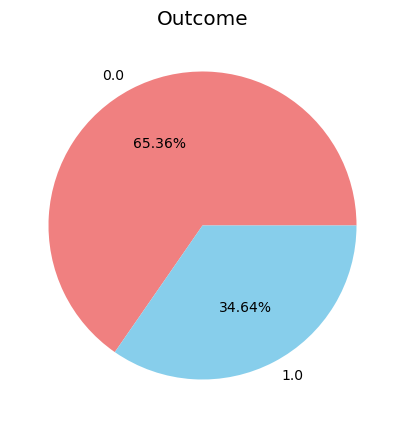

In [15]:
Survived_Counts = df_data['Outcome'].value_counts().reset_index()
Survived_Counts.columns = ['Outcome','Counts']
Survived_Counts
plt.figure( figsize=(10,5) )
df_data['Outcome'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
#df_data['Survived'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'Outcome' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [16]:
Corr_Matrix = df_data.corr()  # 計算相關係數
Corr = Corr_Matrix.loc['Outcome',:].sort_values()[:-1]
Corr = pd.DataFrame({ 'Outcome':Corr })
Corr

,Outcome
PassengerId,-0.089043
BloodPressure,0.166586
SkinThickness,0.176417
DiabetesPedigreeFunction,0.189169
Insulin,0.194083
Pregnancies,0.210434
Age,0.216699
BMI,0.330742
Glucose,0.488177


In [17]:
# 產生訓練集和測試集
Train = df_data[ pd.notnull(df_data.Outcome) ]
Test = df_data[ pd.isnull(df_data.Outcome) ]

# 訓練集刪除 PassengerId 欄位；
# 測試集刪除 PassengerId 與 Survived 欄位
Train.drop( ['PassengerId'], axis=1, inplace=True )
Test.drop( ['PassengerId','Outcome'], axis=1, inplace=True )

# 將測試集中的標籤欄位 Survived 單獨拆出
Y_Train = Train.Outcome
X_Train = Train.drop( ['Outcome'], axis=1 )

print( f'Shape of X_Train = {X_Train.shape}' )
print( f'Shape of Y_Train = {Y_Train.shape}' )
print( f'Shape of Test = {Test.shape}' )

Shape of X_Train = (612, 8)
Shape of Y_Train = (612,)
Shape of Test = (158, 8)


## RandomForestClassifier 隨機森林 ##

In [18]:
# 建立決策樹模型
RFC = RandomForestClassifier( )
# 自變數、應變數進行擬合
RFC.fit( X_Train, Y_Train )

# 排序特徵重要性(由大到小)
col_names = X_Train.columns
importances = RFC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True ) 
Feature_Rank

,Feature_Name,Importance
1,Glucose,0.242890
5,BMI,0.172176
7,Age,0.129080
6,DiabetesPedigreeFunction,0.127557
4,Insulin,0.093143
2,BloodPressure,0.085472
0,Pregnancies,0.077257
3,SkinThickness,0.072425


In [19]:
RFC = RandomForestClassifier( n_estimators = 1000, min_samples_split = 20, min_samples_leaf = 1, oob_score = True, random_state = 1, n_jobs = -1 ) 

In [20]:
RFC.fit( X_Train, Y_Train )
print( 'oob_score = {:.6f}'.format(RFC.oob_score_) )

oob_score = 0.767974


In [21]:
# 建立決策樹模型
RFC = RandomForestClassifier( )
# 自變數、應變數進行擬合
RFC.fit( X_Train, Y_Train )

# 排序特徵重要性(由大到小)
col_names = X_Train.columns
importances = RFC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True ) 
Feature_Rank

,Feature_Name,Importance
1,Glucose,0.243162
5,BMI,0.165395
7,Age,0.136873
6,DiabetesPedigreeFunction,0.125157
2,BloodPressure,0.090899
4,Insulin,0.085920
3,SkinThickness,0.081133
0,Pregnancies,0.071461


In [22]:
RFC = RandomForestClassifier( n_estimators = 1000, min_samples_split = 20, min_samples_leaf = 1, oob_score = True, random_state = 1, n_jobs = -1 ) 

In [23]:
RFC.fit( X_Train, Y_Train )
print( '準確度 = {:.6f}'.format(RFC.oob_score_) )

準確度 = 0.767974


## 重新選擇特徵 ##

In [24]:
RFC_2 = RandomForestClassifier( n_estimators = 1000,
                                min_samples_split = 20,
                                min_samples_leaf = 1,
                                oob_score = True,
                                random_state = 1,
                                n_jobs = -1 ) 

# 篩選部份特徵欄位餵入模型進行訓練
SelectedFeatures = ['Glucose','BMI','DiabetesPedigreeFunction','Age']
RFC_2.fit( X_Train[SelectedFeatures], Y_Train )

print(f'Selected Features :\n   {SelectedFeatures}')
print( '準確度 = {:.6f}'.format(RFC_2.oob_score_) )

Selected Features :
   ['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
準確度 = 0.774510


# 嘗試使用 GridSearchCV

In [25]:
df = pd.read_csv('./diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [26]:
df1 = df.drop(['Outcome','Pregnancies'],axis=1)
#df1 = df.drop('Pregnancies',axis=1)
df1.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148,72,35,0,33.6,0.627,50
1,85,66,29,0,26.6,0.351,31
2,183,64,0,0,23.3,0.672,32
3,89,66,23,94,28.1,0.167,21
4,137,40,35,168,43.1,2.288,33


## 把所有的0值更換為NaN ##

In [27]:
df1.replace(0, np.nan, inplace=True)

In [28]:
df1.head(666)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148.0,72.0,35.0,NaN,33.6,0.627,50
1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,183.0,64.0,NaN,NaN,23.3,0.672,32
3,89.0,66.0,23.0,94.0,28.1,0.167,21
4,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...
661,199.0,76.0,43.0,NaN,42.9,1.394,22
662,167.0,106.0,46.0,231.0,37.6,0.165,43
663,145.0,80.0,46.0,130.0,37.9,0.637,40
664,115.0,60.0,39.0,NaN,33.7,0.245,40


In [29]:
df1.isnull().sum()

Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

## 將所以將不為0的特徵值列出來，並且每行取平均後，進行補缺失值的動作

In [30]:
Missing_FEATURES = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age']
for feature in Missing_FEATURES:
    # 計算平均值
    mean_value = df1[feature].mean()
    # 用平均值填充缺失值
    df1[feature] = df1[feature].replace(0, np.nan) #把所有的0轉為NaN
    df1[feature].fillna(mean_value, inplace=True)
df1.head()            

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148.0,72.0,35.00000,155.548223,33.6,0.627,50
1,85.0,66.0,29.00000,155.548223,26.6,0.351,31
2,183.0,64.0,29.15342,155.548223,23.3,0.672,32
3,89.0,66.0,23.00000,94.000000,28.1,0.167,21
4,137.0,40.0,35.00000,168.000000,43.1,2.288,33


In [31]:
df1["Pregnancies"]=df["Pregnancies"]
df1["Outcome"]=df["Outcome"]
df1.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies,Outcome
0,148.0,72.0,35.00000,155.548223,33.6,0.627,50,6,1
1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,1,0
2,183.0,64.0,29.15342,155.548223,23.3,0.672,32,8,1
3,89.0,66.0,23.00000,94.000000,28.1,0.167,21,1,0
4,137.0,40.0,35.00000,168.000000,43.1,2.288,33,0,1


In [32]:
x = df1.drop('Outcome', axis=1)
y = df1['Outcome']

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [34]:
df_s = scaler.fit_transform(x)
#df1 = scaler.fit_transform(x)

In [35]:
#data = pd.DataFrame(df_s, columns=x.columns)
#data.head()
data = pd.DataFrame(df1, columns=x.columns)
data.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
0,148.0,72.0,35.00000,155.548223,33.6,0.627,50,6
1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,1
2,183.0,64.0,29.15342,155.548223,23.3,0.672,32,8
3,89.0,66.0,23.00000,94.000000,28.1,0.167,21,1
4,137.0,40.0,35.00000,168.000000,43.1,2.288,33,0


In [36]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [37]:
'''from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}'''

"from sklearn import svm\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.linear_model import LogisticRegression\n\nmodel_params = {\n    'svm': {\n        'model': svm.SVC(gamma='auto'),\n        'params' : {\n            'C': [1,10,20],\n            'kernel': ['rbf','linear']\n        }  \n    },\n    'random_forest': {\n        'model': RandomForestClassifier(),\n        'params' : {\n            'n_estimators': [1,5,10]\n        }\n    },\n    'logistic_regression' : {\n        'model': LogisticRegression(solver='liblinear',multi_class='auto'),\n        'params': {\n            'C': [1,5,10]\n        }\n    }\n}"

In [38]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            #'RandomForestRegressor__max_features': [4], 
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'SVC__C' : [1,5,10],
            #'SVC__kernel': ['poly','rbf']   
        }
    }
}

In [39]:
x_train

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
698,127.0,88.0,11.00000,155.000000,34.5,0.598,28,4
258,193.0,50.0,16.00000,375.000000,25.9,0.655,24,1
409,172.0,68.0,49.00000,579.000000,42.4,0.702,28,1
361,158.0,70.0,29.15342,155.548223,29.8,0.207,63,5
299,112.0,72.0,29.15342,155.548223,23.6,0.840,58,8
...,...,...,...,...,...,...,...,...
654,106.0,70.0,28.00000,135.000000,34.2,0.142,22,1
741,102.0,44.0,20.00000,94.000000,30.8,0.400,26,3
588,176.0,86.0,27.00000,156.000000,33.3,1.154,52,3
513,91.0,62.0,29.15342,155.548223,27.3,0.525,22,2


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Confusion matrix :
[[131  16]
 [ 52  32]]
Accuracy : 0.706
ROC_AUC score : 0.64
Precision : 0.67
Recall : 0.38


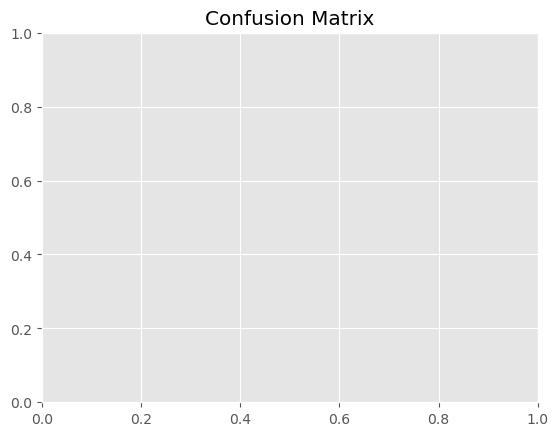

In [45]:
from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,
                             roc_curve,classification_report,
                             roc_auc_score, roc_curve,auc,
                             accuracy_score,confusion_matrix)
def predict(algorithm, rfe_features, x_train, y_train, x_test, y_test):
    
    # use selected x best features to fit model
    if rfe_features is not None:
        x_train = x_train[rfe_features]
        x_test = x_test[rfe_features]
    
    algorithm_fit = algorithm.fit(x_train, y_train)

    # predict 
    y_pred = algorithm.predict(x_test)
    
    # confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    print('Confusion matrix :')
    print(confusion_mat)
    TP = confusion_mat[1, 1]
    TN = confusion_mat[0, 0]
    FP = confusion_mat[0, 1]
    FN = confusion_mat[1, 0]
    #plot confusion matrix 
    #ConfusionMatrixDisplay(algorithm_fit, x_test, y_test, cmap=plt.cm.Blues,display_labels=['No Diabetes','Diabetes'])
    #>> clf = SVC(random_state=0)
    #>>> clf.fit(X_train, y_train)
    predictions = algorithm_fit.predict(x_test)
    cm = confusion_matrix(y_test, predictions, labels=algorithm_fit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes','Diabetes'])
    
    plt.title('Confusion Matrix')
    
    # accuracy
    accuracy = algorithm.score(x_test, y_test)
    # print((TP+TN)/ (TN+TP+FP+FN))
    print('Accuracy : {:.3f}'.format(accuracy))
    
    # ROC_AUC score
    logit_roc_auc = roc_auc_score(y_test, algorithm.predict(x_test))
    print('ROC_AUC score : %0.2f' % logit_roc_auc)
    
    # Precision
    precision = TP/(TP+FP)
    print('Precision : %0.2f' % precision)
    
    # Recall
    recall = TP/(TP + FN)
    print('Recall : %0.2f' % recall)
    
# Using all features
parameters = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20)}
logit = GridSearchCV(LogisticRegression(random_state=0),parameters,cv = 5, verbose=True, n_jobs=-1)
predict(logit, None, x_train, y_train, x_test, y_test)

In [46]:
from sklearn.model_selection import GridSearchCV

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

ValueError: Invalid parameter 'SVC' for estimator LogisticRegression(solver='liblinear'). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].

In [ ]:
from sklearn.model_selection import GridSearchCV

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

## 由上圖可以比較每個模型使用GridSearch最好的參數與表現，與第一次報告使用挑選特定特徵的準確度沒有太大的差異